<h1 style="color:orange">One group estimation</h1>

<p>The example used in this section could be found at <a href="https://github.com/fonnesbeck/bayes_course_2022/blob/main/notebooks/Section1_1-Basic_Bayes.ipynb">Fonnesbeck C,</a>. The dasaset used in this example as well the model conception was described by Gelman et al (2007). The ideia was to measure the level of the radioactive gas radon among different househoulds at counties level off different states from USA. Radon gas is know yo be the highest cause of lung cancer in non-smokers. Probably its presence is more evident in houses that contains a basement.</p>
<p>The US Environmental Protection Agency (EPA) has set that the tolerance level for this fas is about 4 pCi/L. At or above this level of randon, EPA recommends that person takes corrective measures to reduce this level.</p>
<p>Of the frequentist point of Hypothesis test we are to concern if the level of randon is statistically "different" of 4 pCi/L</p>

In [1]:
#import libraries
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = 20, 14

In [3]:
#read dataset
data = pd.read_csv("../data/radon.csv", index_col = 0)
data.head()

idnum state state2  stfips    zip  region  typebldg  floor  room basement  \
0  5081.0    MN     MN    27.0  55735     5.0       1.0    1.0   3.0        N   
1  5082.0    MN     MN    27.0  55748     5.0       1.0    0.0   4.0        Y   
2  5083.0    MN     MN    27.0  55748     5.0       1.0    0.0   4.0        Y   
3  5084.0    MN     MN    27.0  56469     5.0       1.0    0.0   4.0        Y   
4  5085.0    MN     MN    27.0  55011     3.0       1.0    0.0   4.0        Y   

   ... pcterr        adjwt  dupflag  zipflag  cntyfips  county     fips  \
0  ...    9.7  1146.499190      1.0      0.0       1.0  AITKIN  27001.0   
1  ...   14.5   471.366223      0.0      0.0       1.0  AITKIN  27001.0   
2  ...    9.6   433.316718      0.0      0.0       1.0  AITKIN  27001.0   
3  ...   24.3   461.623670      0.0      0.0       1.0  AITKIN  27001.0   
4  ...   13.8   433.316718      0.0      0.0       3.0   ANOKA  27003.0   

       Uppm  county_code  log_radon  
0  0.502054            0   0.832909  
1  0.502054            0   0.832909  
2  0.502054            0   1.098612  
3  0.502054            0   0.095310  
4  0.428565            1   1.163151  

[5 rows x 29 columns]

<p>To keep things simpe we are only estimate the parameter for a sinle county. In this case we are gonna to evaluate the radon level at log scale</p> 

In [4]:
#select a county
aitikin = data.query("county == 'AITKIN'")

<p>Recall the the three steps to perfom bayesian analysis consist of: (i) define a model in terms of probability, (ii) Ccompute posterior distribution and (iii) check our model</p>

<h2 style="color:orange">Define model in terms of probability</h2>

<p> During this phase we must define a likelihood function(s) for the observations (p(D|&Theta;)) and give priors (p(&Theta;)) for all unknown quantities<\p>
<p> As the value of our variable are in log scale is safe start with a normal distribuiton. We could also check this assumption later so, don't worry </p>

<p>So we have:</p>

$y_i \sim N(\mu,\sigma^2)$

<p>In this case we have to parameters to give our priors:</p>
<p>$mu$ - since this can take any value we could use another Normal distribution here</p>
<p>$sigma$ - we know that ture value of a standard deviation must be positive so we must give a distribution bounded at 0 anf from above. In this case we could use a uniform r halfNormal distribuition</p>

In [5]:
#using pm code
with pm.Model() as one_group_model:
    
    #define priors for unknow quantities
    mu = pm.Normal("mu", mu = 0, tau = 0.1)
    sigma = pm.Uniform("sigma", lower = 0, upper = 10)
    
    
    #define likelihood
    y_observed = pm.Normal("y_observed", mu = mu, sigma = sigma, observed = aitikin["log_radon"])

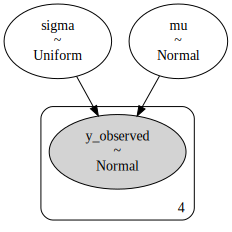

In [6]:
#lets inspect our model 
pm.model_to_graphviz(one_group_model)

<p>The next step is compute posterior. Remember that instead to try to compute p(D) we are gonna to use a numerical approach</p>

In [7]:
with one_group_model:
    
    #using MCMC trough NUTS
    samples  = pm.sample(10000, tune = 3000, cores = 2, random_seed = 42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 3_000 tune and 10_000 draw iterations (6_000 + 20_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<p>Before go any futher lets check our assumption</p>

In [8]:
mus = samples.posterior['mu'].values
sigmas = samples.posterior['sigma'].values
radon_samples = pm.Normal.dist(mus, sigmas).eval()

/tmp/ipykernel_135027/592496876.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(aitikin["log_radon"], label='observed', ax=ax, color='yellow')


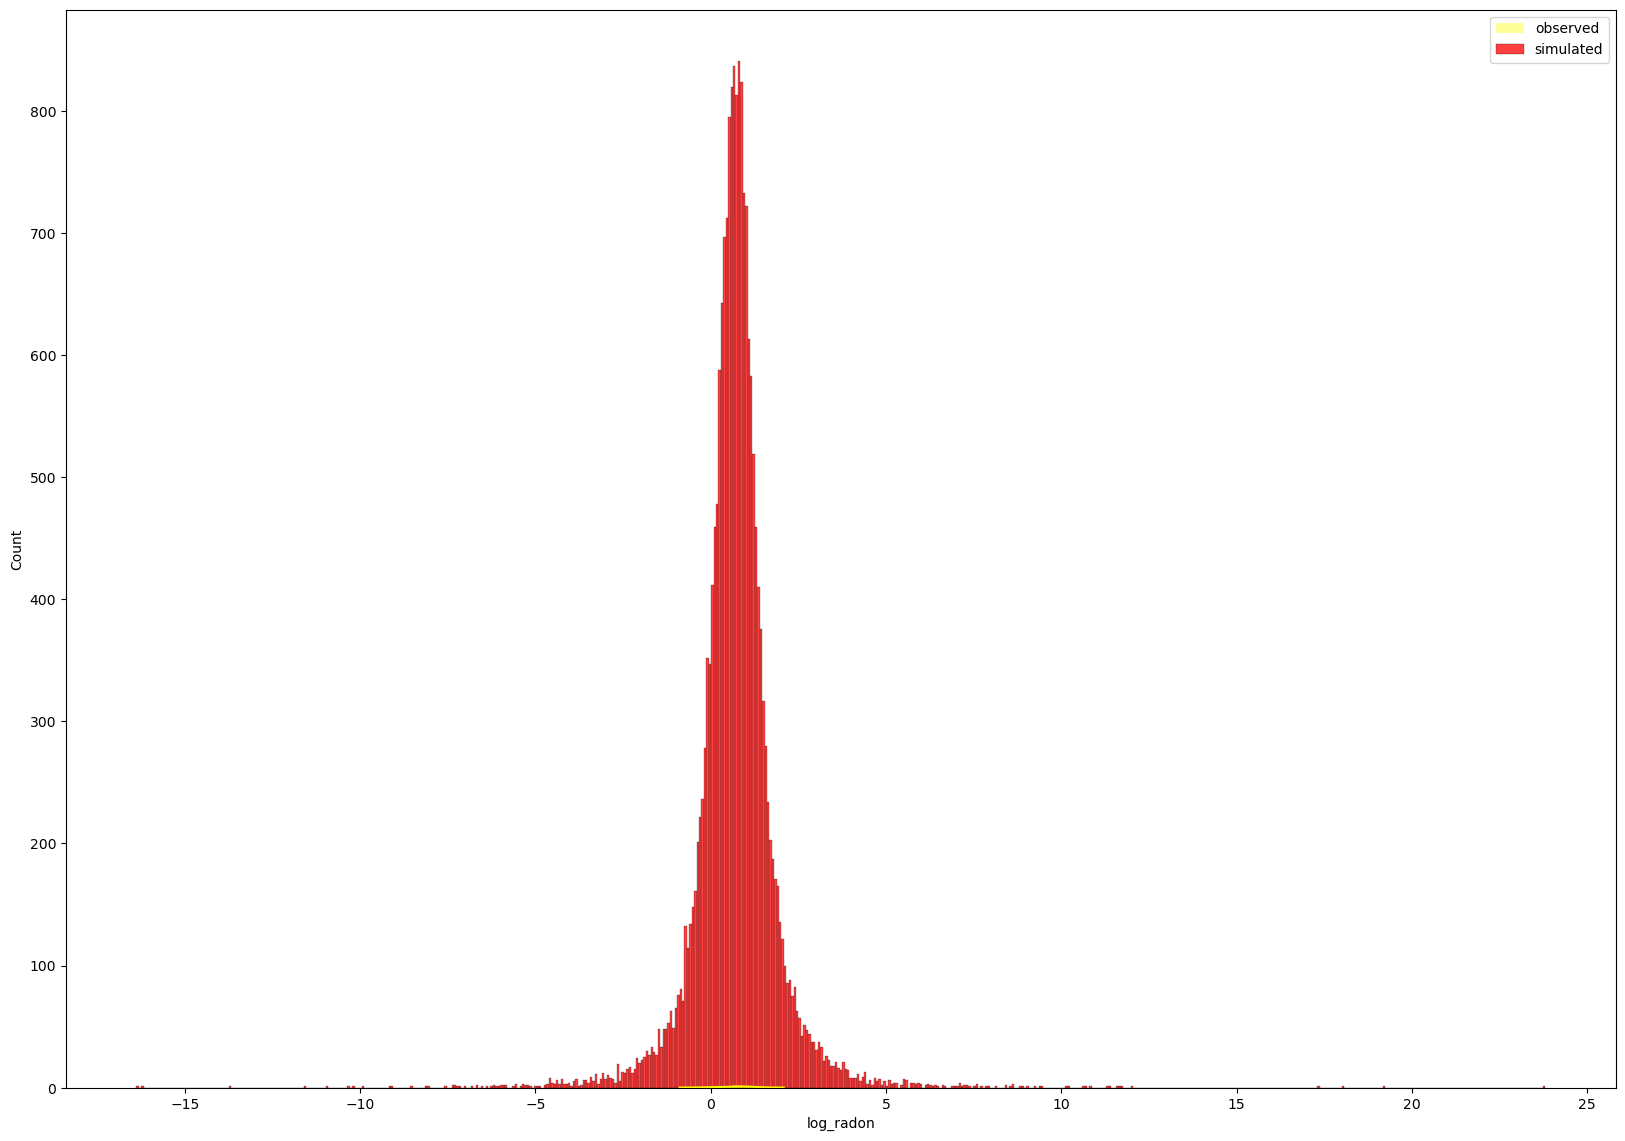

In [9]:
#lets using posterior predctive to check our model
ax = sns.histplot(radon_samples.ravel(), label='simulated', color='red')
sns.distplot(aitikin["log_radon"], label='observed', ax=ax, color='yellow')
plt.legend();

<p>We could also check chains convergence and Rhat statistics</p>

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

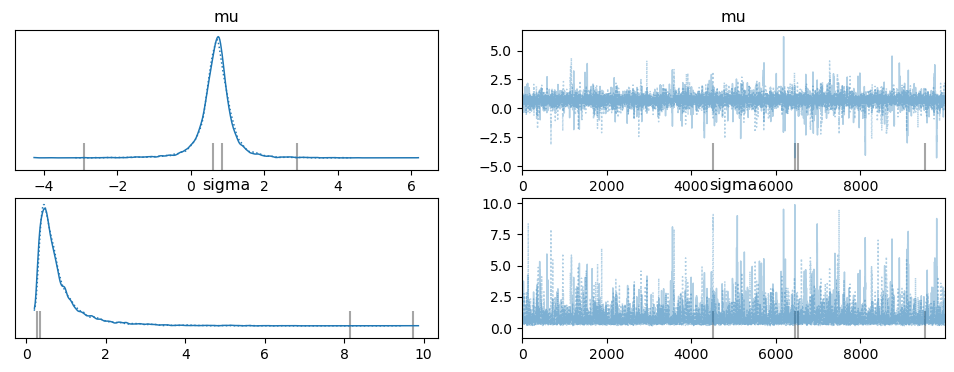

In [10]:
az.plot_trace(samples)

In [11]:
az.summary(samples)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.697  0.514  -0.284    1.611      0.008    0.006    5370.0    4002.0   
sigma  0.847  0.739   0.198    1.968      0.014    0.010    3367.0    3859.0   

       r_hat  
mu       1.0  
sigma    1.0

<p>Now it's time to make inference.</p>

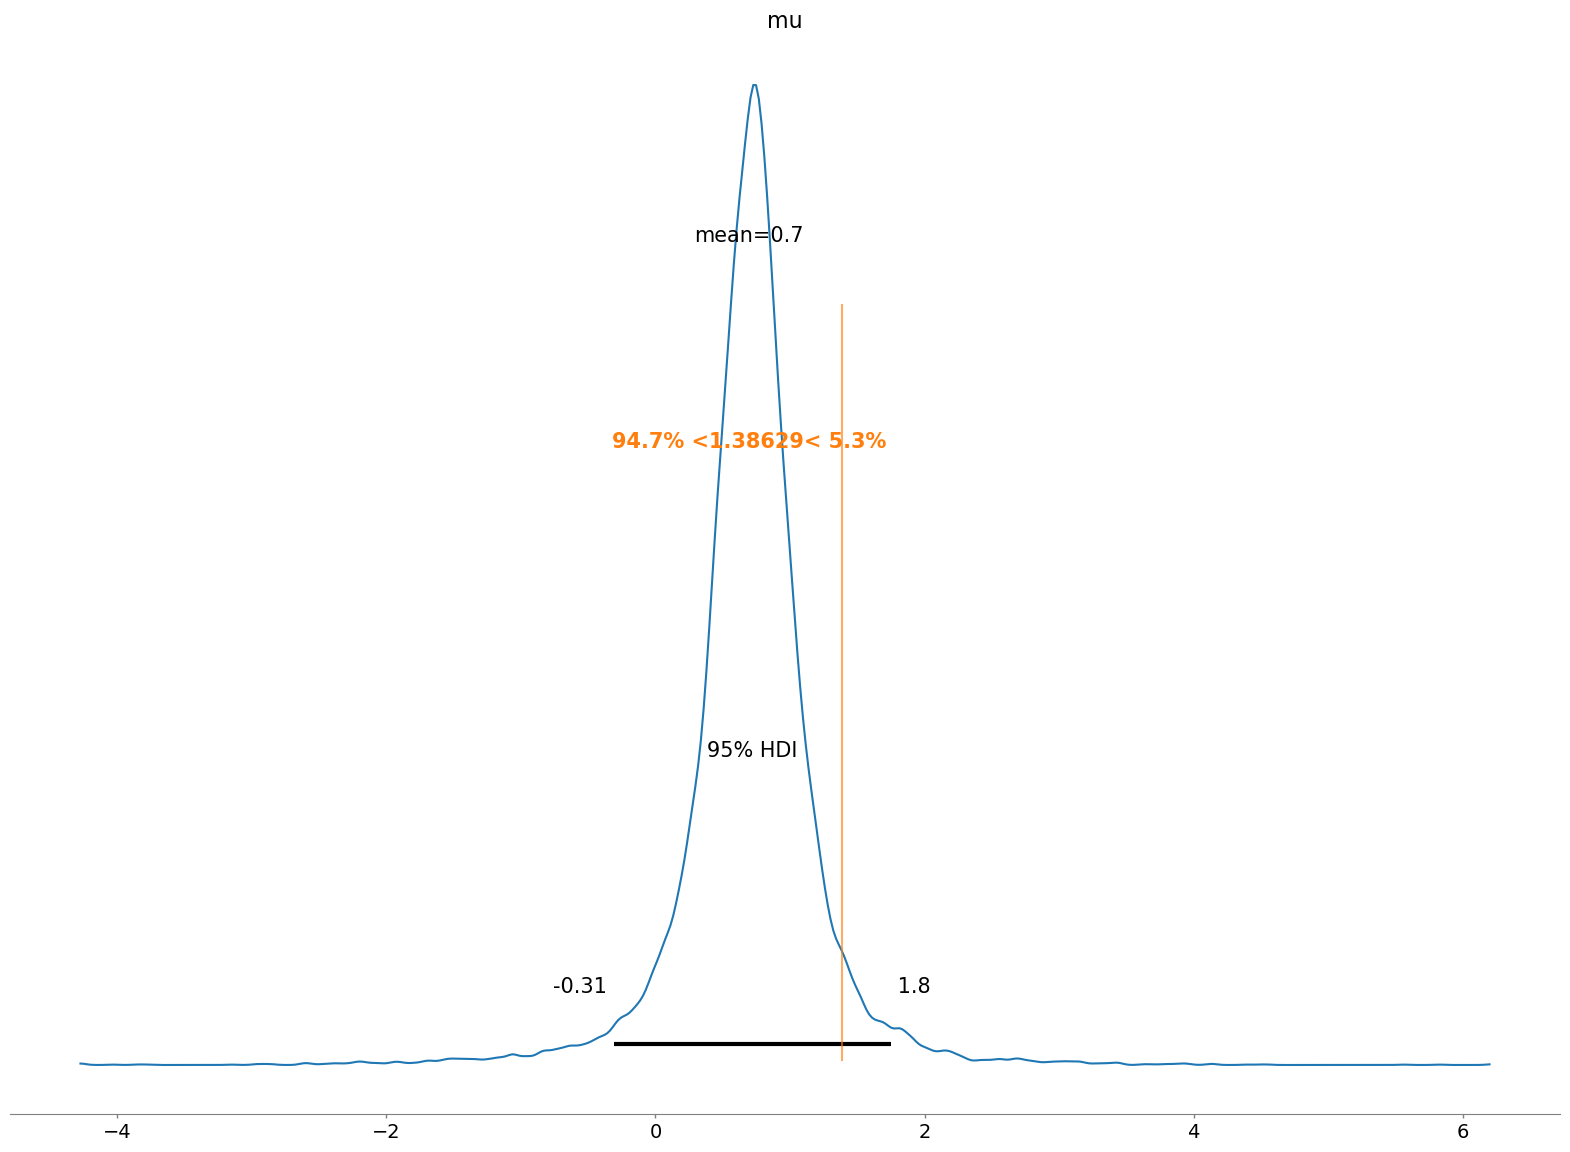

In [12]:
az.plot_posterior(samples, var_names=['mu'], ref_val=np.log(4), hdi_prob=0.95);

<p>The graph above tell us that the posterior probability that the mean level of houseold radon in Aitikin is greater than 4 pCi/L is 0.05</p>

<p>So we are interested in know how probably is value in our posterior be equal or greater than 4 pCi/L. In other words in are interested in know what is the probability of a random househould has radon value equal or gretaer than 4 pCi/L</p>

In [13]:
(radon_samples > np.log(4)).mean()

0.17815

<p>The posterior porbability that a randomly-selected househould in Aitikin contains randon level in excess of 4 pCi/L is about 0.17</p>

In [14]:
print("done")

done


<h2>References</h2>

<p>Gelman, Andrew, John B. Carlin, Hal S. Stern, David B. Dunson, Aki Vehtari, and Donald B. Rubin. 2013. Bayesian Data Analysis, Third Edition. CRC Press.</p>